In [588]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [589]:
import pandas as pd 
data = pd.read_csv('train_1.csv')
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [590]:
data1 = data.iloc[[2]]
data1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [591]:
data10 = data1.copy()

In [592]:
for i in range(1, 550):
    value = data10.iloc[:, i]
    if value.min() == 0.0:
        column_index = data10.columns[i]
        data10[column_index] += 0.1

In [593]:
data.iloc[[2]].isnull().sum().sort_values(ascending = False)

Page          0
2016-07-04    0
2016-06-28    0
2016-06-29    0
2016-06-30    0
             ..
2015-12-25    0
2015-12-24    0
2015-12-23    0
2015-12-22    0
2016-12-31    0
Length: 551, dtype: int64

In [594]:
data10 = pd.melt(data10[list(data10.columns[-100:]) + ['Page']], id_vars='Page', var_name='date', value_name='Visits')

data10['date'] = data10['date'].astype('datetime64[ns]')

data10['weekday'] = data10['date'].apply(lambda x: x.weekday())

In [595]:
data10

,Page,date,Visits,weekday
0,3C_zh.wikipedia.org_all-access_spider,2016-09-23,3.0,4
1,3C_zh.wikipedia.org_all-access_spider,2016-09-24,1.0,5
2,3C_zh.wikipedia.org_all-access_spider,2016-09-25,10.0,6
3,3C_zh.wikipedia.org_all-access_spider,2016-09-26,5.0,0
4,3C_zh.wikipedia.org_all-access_spider,2016-09-27,4.0,1
...,...,...,...,...
95,3C_zh.wikipedia.org_all-access_spider,2016-12-27,4.0,1
96,3C_zh.wikipedia.org_all-access_spider,2016-12-28,6.0,2
97,3C_zh.wikipedia.org_all-access_spider,2016-12-29,3.0,3
98,3C_zh.wikipedia.org_all-access_spider,2016-12-30,4.0,4


In [596]:
data10 = data10.groupby(['date']).agg({'Visits':'sum'}).rename(columns={'Visits':'visit'})

In [597]:
data10

,visit
date,
2016-09-23,3.0
2016-09-24,1.0
2016-09-25,10.0
2016-09-26,5.0
2016-09-27,4.0
...,...
2016-12-27,4.0
2016-12-28,6.0
2016-12-29,3.0


In [598]:
data_new = pd.melt(data1,id_vars=['Page'],var_name='Date',value_name='Visits')
data_new.drop(["Page"], axis = 1, inplace = True)
data_new.head()

,Date,Visits
0,2015-07-01,1.0
1,2015-07-02,0.0
2,2015-07-03,1.0
3,2015-07-04,1.0
4,2015-07-05,0.0


In [599]:
data_new['Date'] = pd.DatetimeIndex(data_new['Date'])
data_new.head()

,Date,Visits
0,2015-07-01,1.0
1,2015-07-02,0.0
2,2015-07-03,1.0
3,2015-07-04,1.0
4,2015-07-05,0.0


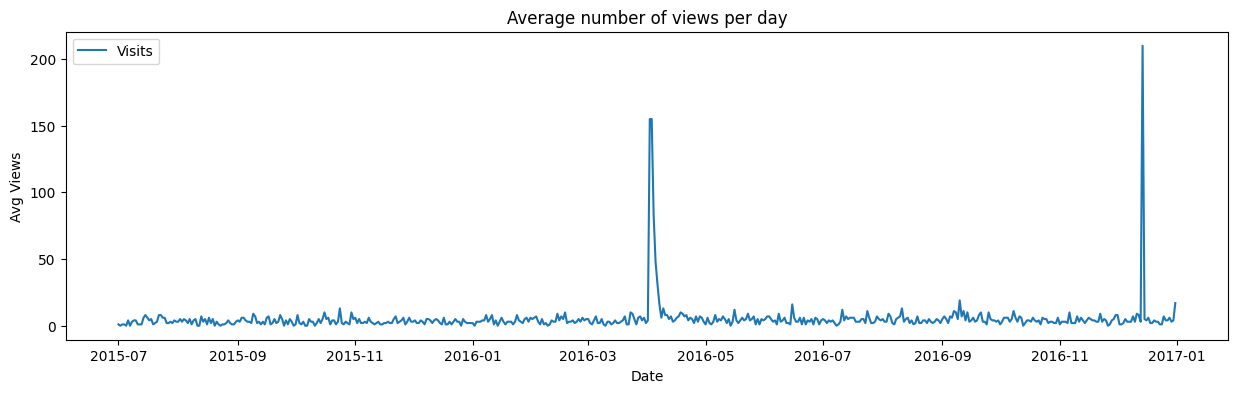

In [600]:
from matplotlib import pyplot as plt
temp = data_new.groupby('Date')['Visits'].mean()
plt.figure(figsize = (15,4))
plt.xlabel('Date')
plt.ylabel('Avg Views')
plt.title('Average number of views per day')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

In [601]:
data4 = data_new.copy()

In [602]:
data4.Visits

0       1.0
1       0.0
2       1.0
3       1.0
4       0.0
       ... 
545     4.0
546     6.0
547     3.0
548     4.0
549    17.0
Name: Visits, Length: 550, dtype: float64

In [603]:

for i in range(1,550):
    value = data4.Visits[i]
    if value > 20.0:
        data4 = data4.drop (index= i)

data4.reset_index(drop=True, inplace=True)
data4.head()

,Date,Visits
0,2015-07-01,1.0
1,2015-07-02,0.0
2,2015-07-03,1.0
3,2015-07-04,1.0
4,2015-07-05,0.0


In [604]:
data4['Date'] = pd.DatetimeIndex(data4['Date'])
data4 = data4.set_index('Date')
data4.head()

,Visits
Date,
2015-07-01,1.0
2015-07-02,0.0
2015-07-03,1.0
2015-07-04,1.0
2015-07-05,0.0


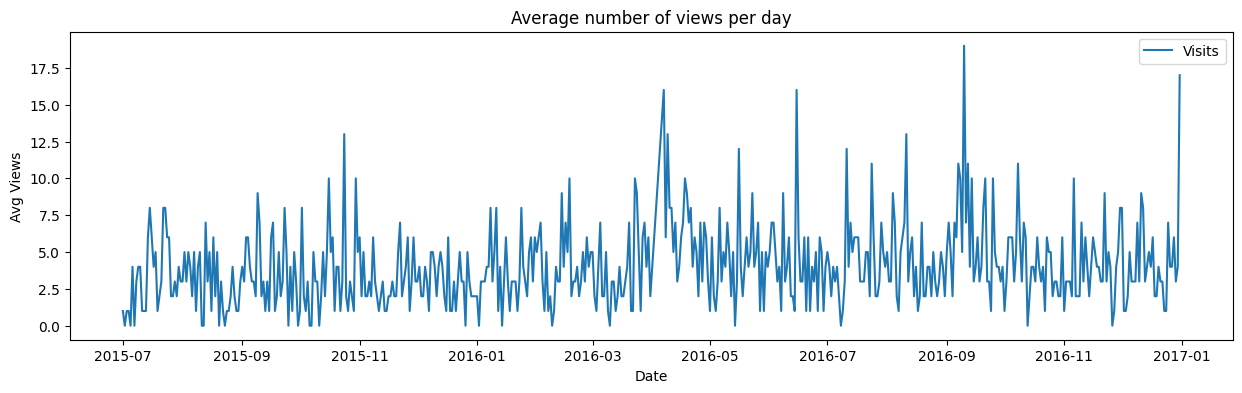

In [605]:
temp = data4.groupby('Date')['Visits'].mean()
plt.figure(figsize = (15,4))
plt.xlabel('Date')
plt.ylabel('Avg Views')
plt.title('Average number of views per day')
plt.plot(temp,label='Visits')
plt.legend()
plt.show()

In [606]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):      
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return 


Оптимальный параметр преобразования Бокса-Кокса: 0.257879


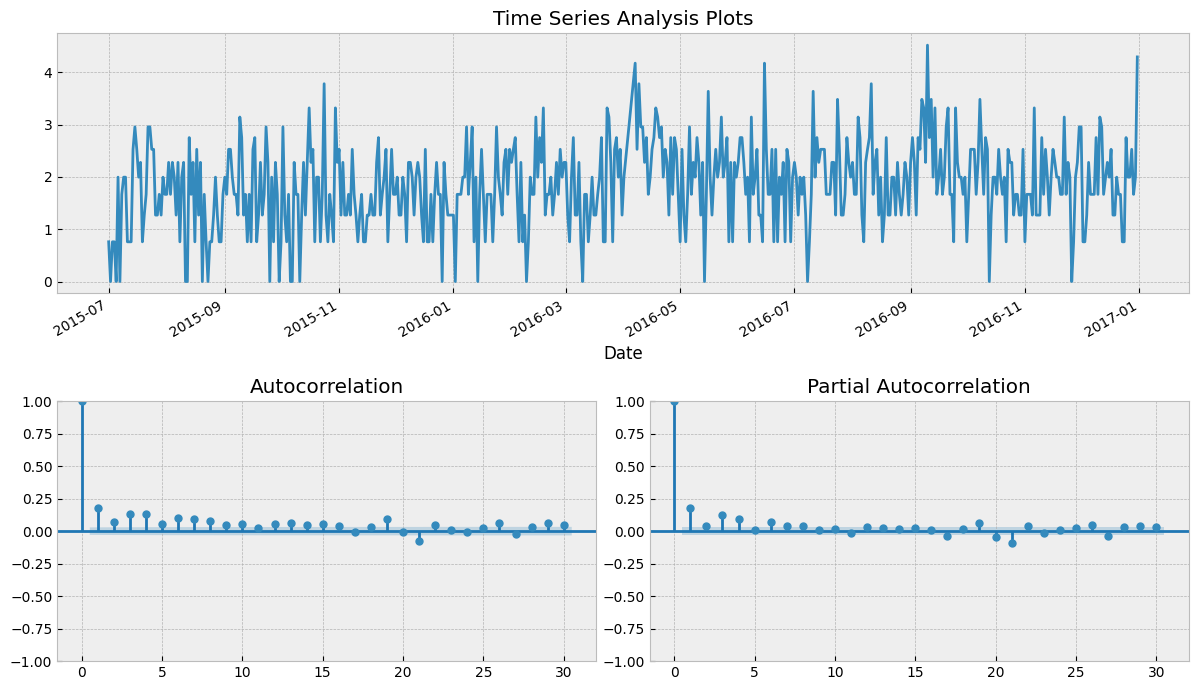

In [607]:
import numpy as np
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
   
data4['Users_box'], lmbda = scs.boxcox(data4.Visits+1) 
tsplot(data4.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

In [608]:
data4['rolling_avg']= data4['Users_box'].rolling(window=7).mean()

<Axes: xlabel='Date', ylabel='Users_box'>

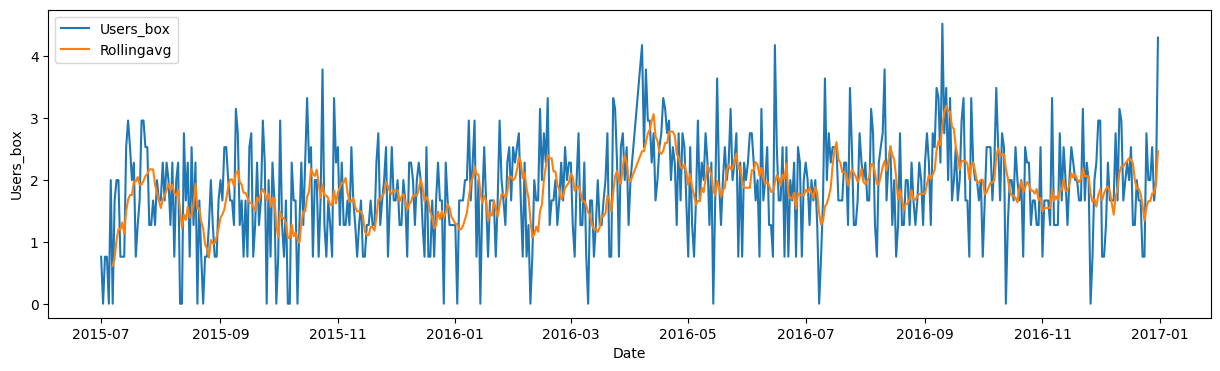

In [609]:
import seaborn as sns
plt.figure(figsize = (15,4))
sns.lineplot( x = 'Date', 
             y = 'Users_box', 
             data = data4, 
             label = 'Users_box') 
sns.lineplot( x = 'Date', 
             y = 'rolling_avg', 
             data = data4, 
             label = 'Rollingavg') 

In [610]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

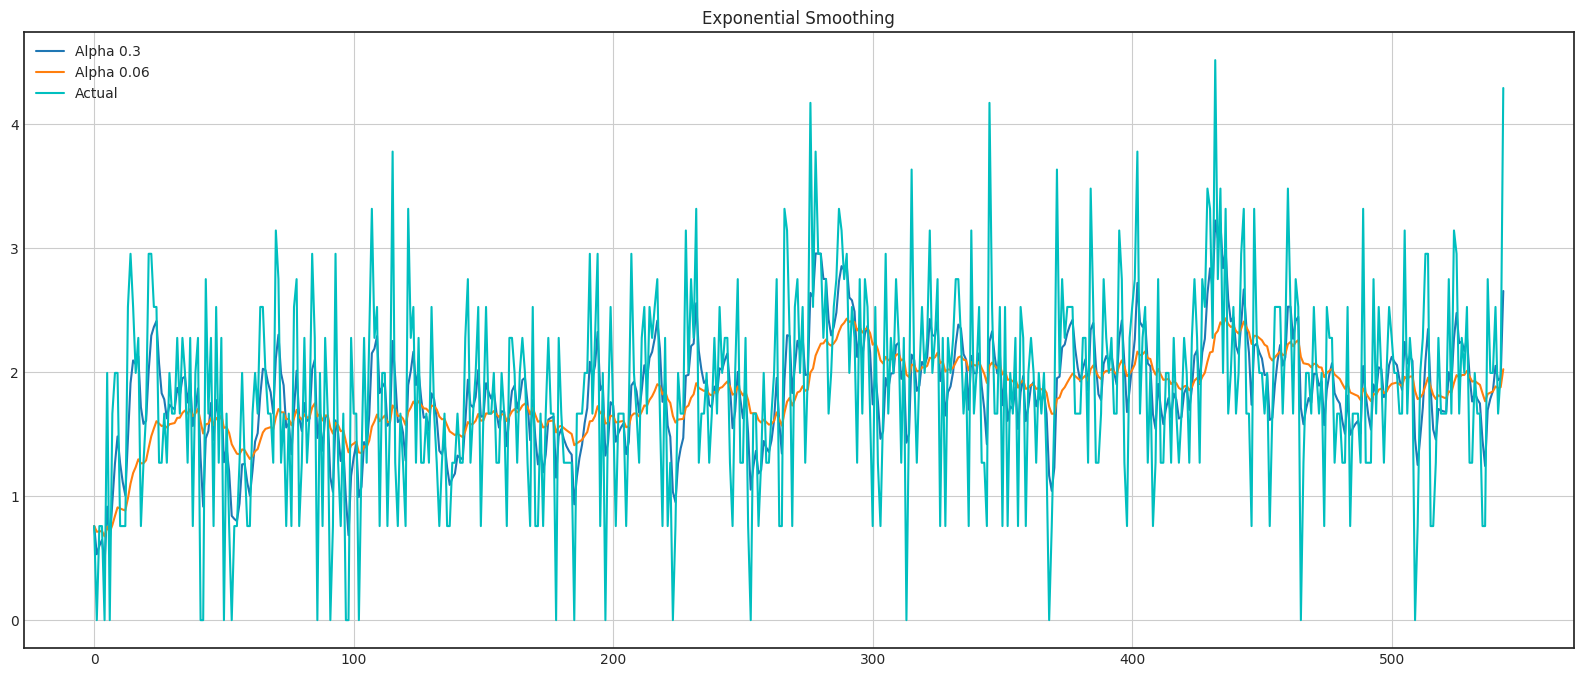

In [611]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.06]:
        plt.plot(exponential_smoothing(data4.Users_box, alpha), label="Alpha {}".format(alpha))
    plt.plot(data4.Users_box.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
num = 1.5
alph = 0.3
data4['Exp_visits'] = exponential_smoothing(data4.Users_box, alph)   

In [612]:
data4.head()

,Visits,Users_box,rolling_avg,Exp_visits
Date,,,,
2015-07-01,1.0,0.758959,NaN,0.758959
2015-07-02,0.0,0.000000,NaN,0.531271
2015-07-03,1.0,0.758959,NaN,0.599577
2015-07-04,1.0,0.758959,NaN,0.647392
2015-07-05,0.0,0.000000,NaN,0.453174


In [613]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [614]:
def in_val(arr, n, x1, x2):
    for i in range(x1,x2):
       arr[i] -=n
    return arr

In [615]:
def zer_val(arr):
    for i in range(1,599):
       arr[i]*=0.5
       if arr[i] < 0:
         arr[i] = 0  
       if arr[i] >22:
         arr[i] = 22  
    return arr

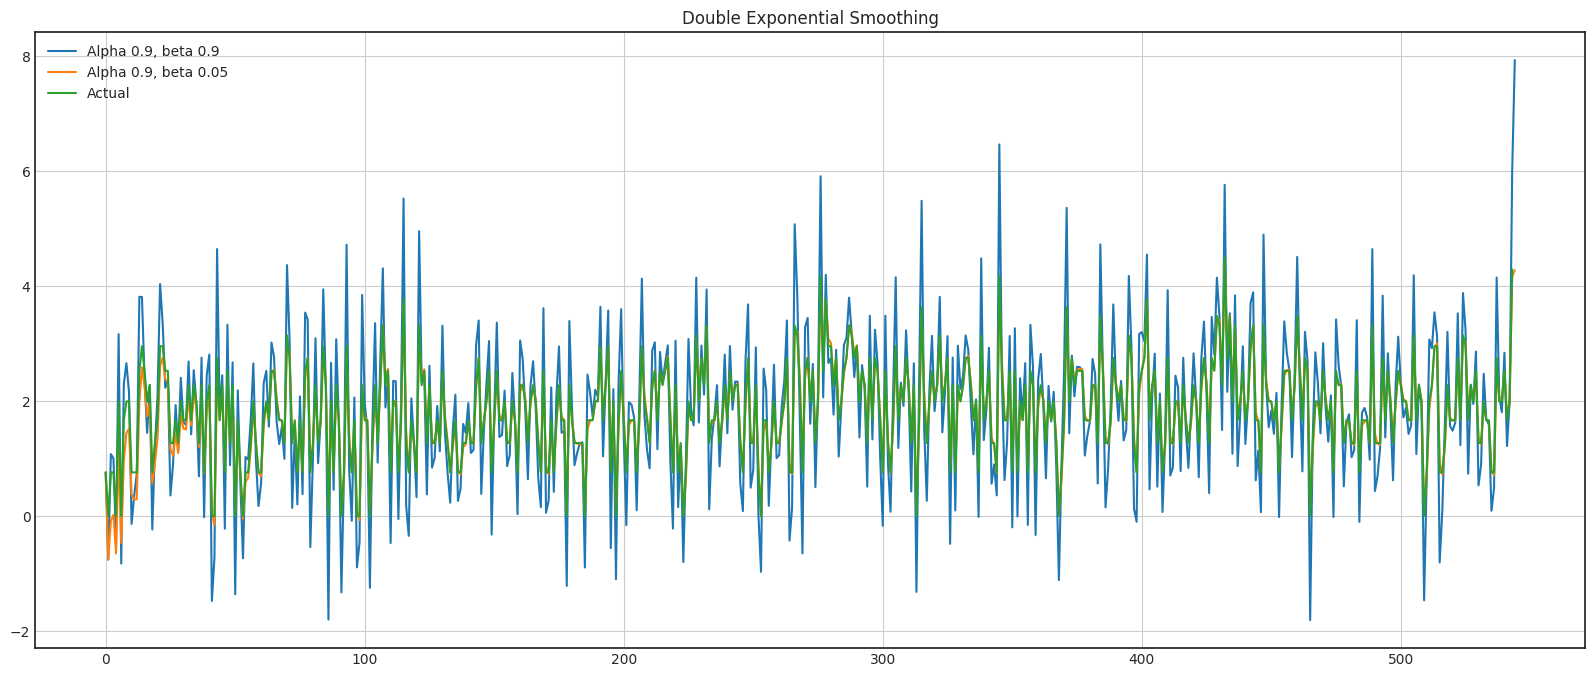

In [ ]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9]:
        for beta in [0.9, 0.05]:
            plt.plot(double_exponential_smoothing(data4.Users_box, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data4.Users_box.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [ ]:

print('Результат теста:')
df_result = adfuller(data4['Users_box'])
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Ряд является стационарным.")
else:
    print("Ряд не является стационарным.")

Результат теста:
ADF Test Statistic : -8.977496647193213
p-value : 7.463242825510956e-15
#Lags Used : 3
Number of Observations Used : 540
Ряд является стационарным.


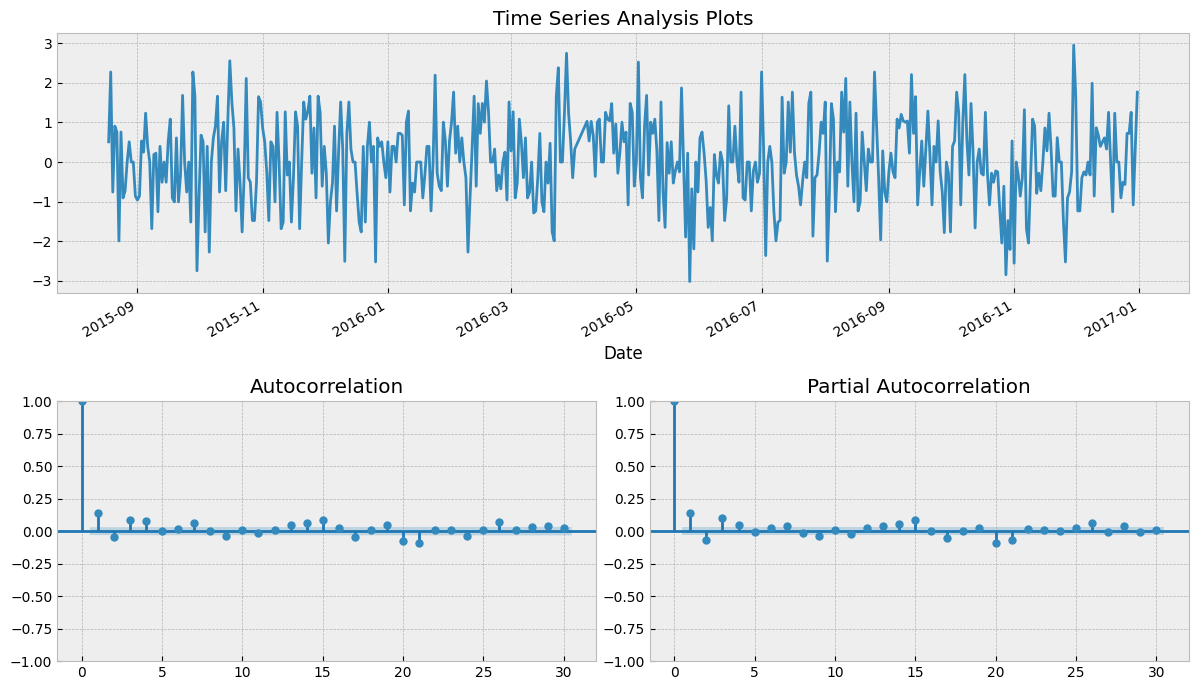

In [ ]:
data4['Users_box_season'] = data4.Users_box - data4.Users_box.shift(48)
tsplot(data4.Users_box_season[48:], lags=30)

In [ ]:
best_model1 = sm.tsa.statespace.SARIMAX(data4.Visits, order=(1, 1, 1), 
                                        seasonal_order=(1, 0, 1, 12)).fit(disp=-1)
print(best_model1.summary())    

                                     SARIMAX Results                                      
Dep. Variable:                             Visits   No. Observations:                  544
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1299.724
Date:                            Fri, 19 Apr 2024   AIC                           2609.448
Time:                                    12:43:29   BIC                           2630.934
Sample:                                         0   HQIC                          2617.849
                                            - 544                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1061      0.053      2.015      0.044       0.003       0.209
ma.L1         -0.9694      0.012   

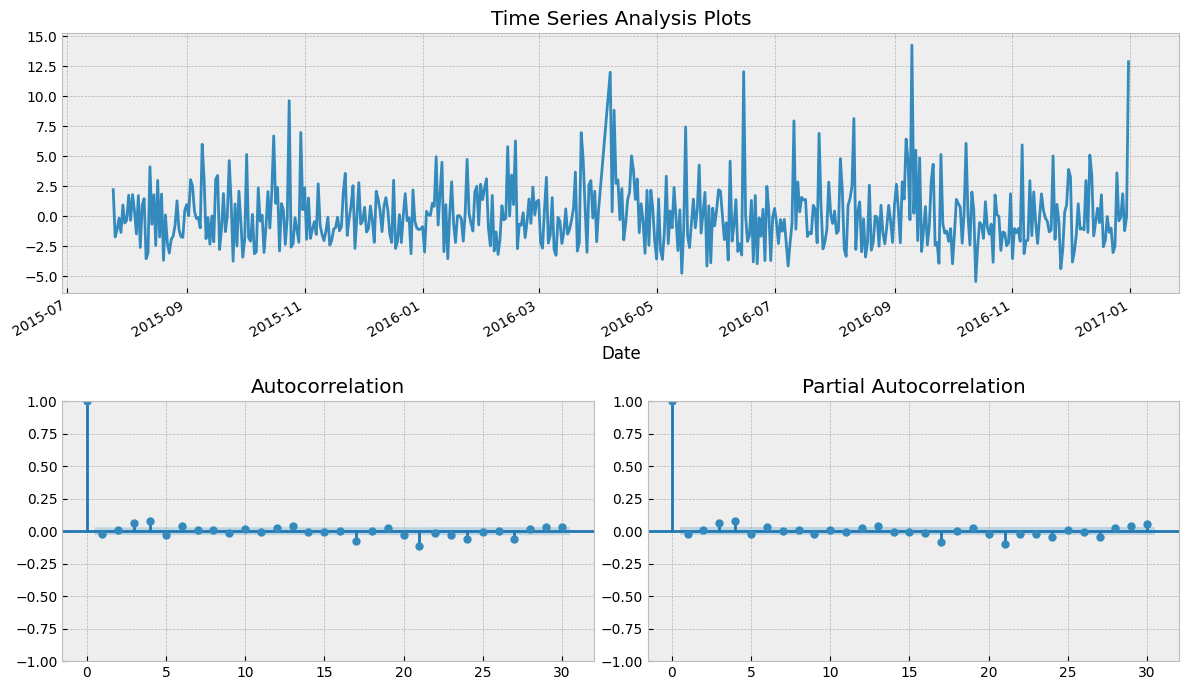

In [ ]:
tsplot(best_model1.resid[24:], lags=30)

In [ ]:
data4["arima_model"] = invboxcox(best_model1.fittedvalues, lmbda)
forecast = invboxcox(best_model1.predict(start = data4.shape[0], end = data4.shape[0]+100), lmbda)
forecast = data4.arima_model._append(forecast).values[-600:]
forecast = in_val(forecast, 7, 1, 239)
forecast = in_val(forecast, 14, 240, 380)
forecast = in_val(forecast, 13, 381, 500) 
forecast = zer_val(forecast)
actual = data4.Visits.values[-500:]


In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data4.Users_box, order=(1, 1, 1), 
                                        seasonal_order=(1, 0, 1, 12)).fit(disp=-1)

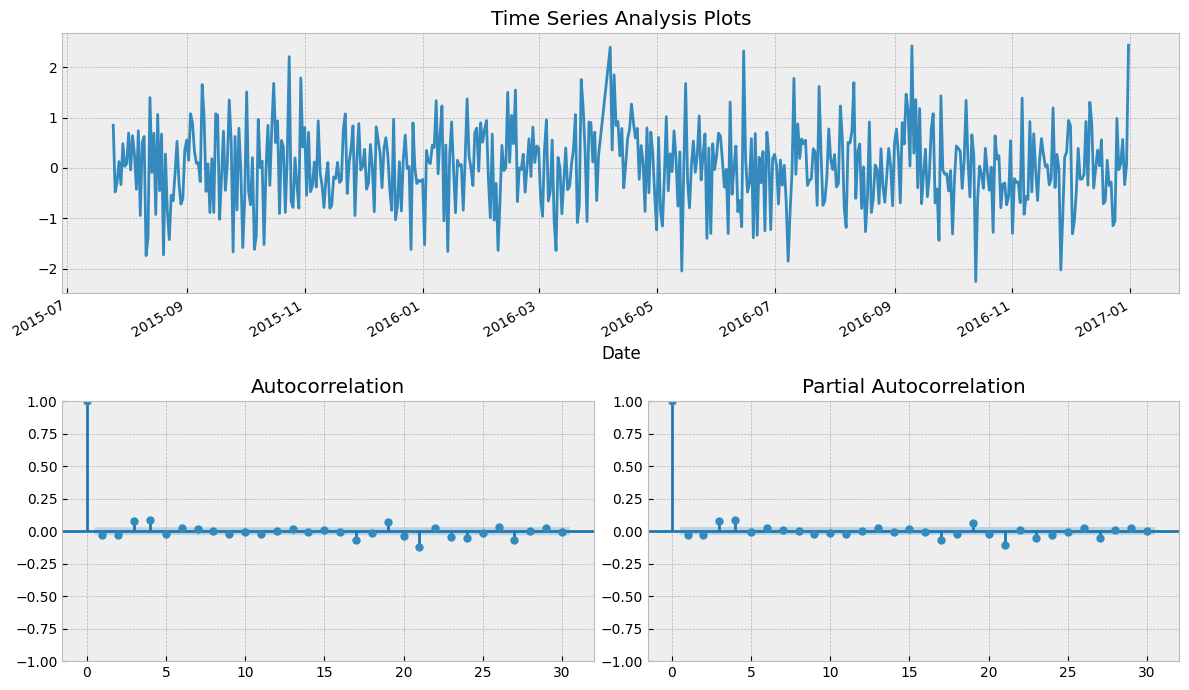

In [ ]:
tsplot(best_model.resid[24:], lags=30)

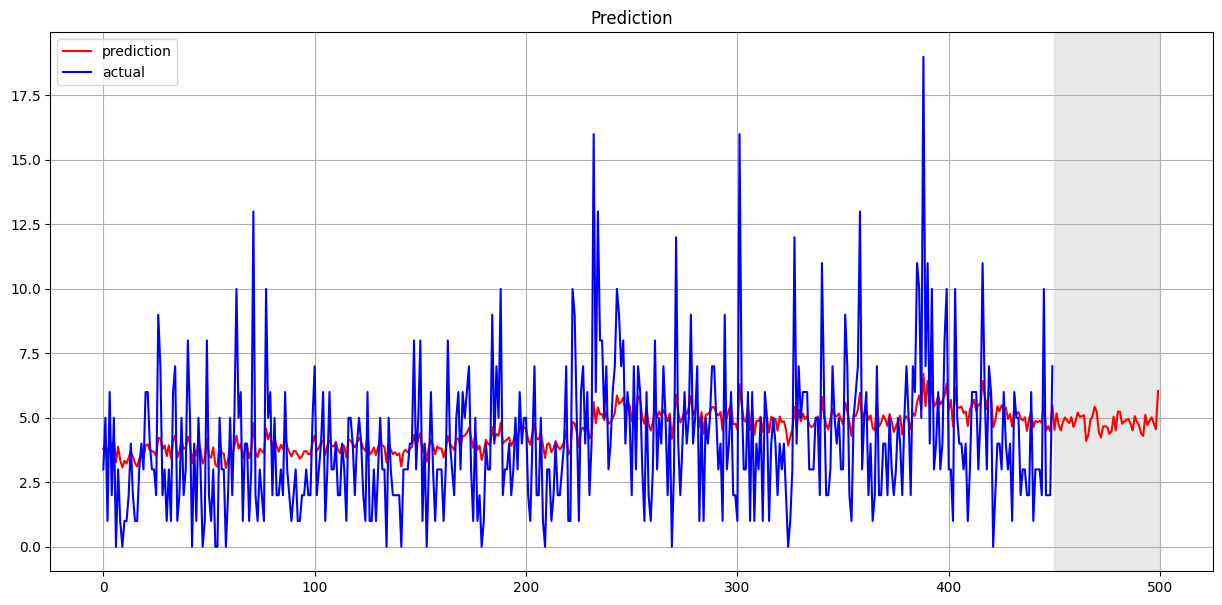

In [617]:
data4["arima_model1"] = invboxcox(best_model.fittedvalues, lmbda)
forecast1 = invboxcox(best_model.predict(start = data4.shape[0], end = data4.shape[0]+100), lmbda)
forecast1 = data4.arima_model1._append(forecast1).values[-600:]
#forecast = in_val(forecast, 7, 1, 239)
#forecast = in_val(forecast, 14, 240, 380)
#forecast = in_val(forecast, 13, 381, 500) 
#forecast = zer_val(forecast)
actual = data4.Visits.values[-500:]
plt.figure(figsize=(15, 7))
daata = actual[:450]
forecast1 = forecast1[:500]
plt.plot(forecast1, color='red', label="prediction")
plt.title("Prediction")
plt.plot(daata, color='blue', label="actual")
plt.legend()
plt.axvspan(len(forecast1), len(daata), alpha=0.5, color='lightgrey')
plt.grid(True)

In [ ]:
data4.head()

,Visits,Users_box,rolling_avg,Exp_visits,Users_box_season,arima_model
Date,,,,,,
2015-07-01,1.0,0.758959,NaN,0.758959,NaN,1.000000
2015-07-02,0.0,0.000000,NaN,0.531271,NaN,2.434314
2015-07-03,1.0,0.758959,NaN,0.599577,NaN,1.526131
2015-07-04,1.0,0.758959,NaN,0.647392,NaN,1.942191
2015-07-05,0.0,0.000000,NaN,0.453174,NaN,2.051403


In [ ]:
#data4.drop(["Visits"], axis = 1, inplace = True)
data4.drop(["arima_model"], axis = 1, inplace = True)
data4.drop(["rolling_avg"], axis = 1, inplace = True)
data4.drop(["Users_box_season"], axis = 1, inplace = True)
data4.drop(["Exp_visits"], axis = 1, inplace = True)
actual1 = actual[:450]
model1 = forecast[:500]
#data4.drop(["Users_box"], axis = 1, inplace = True)

In [ ]:
data4.head()

,Visits,Users_box
Date,,
2015-07-01,1.0,0.758959
2015-07-02,0.0,0.000000
2015-07-03,1.0,0.758959
2015-07-04,1.0,0.758959
2015-07-05,0.0,0.000000


In [ ]:
def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
train = data4[:'2016-09']
test = data4['2016-10':]

In [ ]:
time_steps = 10
X_train, y_train = transform_dataset(train, train.Users_box, time_steps)
X_test, y_test = transform_dataset(test, test.Users_box, time_steps)

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding,LSTM

model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=20,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam()
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/20
25/25 [==============================] - 5s 48ms/step - loss: 1.7698 - val_loss: 1.3137
Epoch 2/20
25/25 [==============================] - 0s 11ms/step - loss: 0.6390 - val_loss: 0.6778
Epoch 3/20
25/25 [==============================] - 0s 13ms/step - loss: 0.6585 - val_loss: 0.7000
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6389 - val_loss: 0.6941
Epoch 5/20
25/25 [==============================] - 0s 12ms/step - loss: 0.6328 - val_loss: 0.6727
Epoch 6/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6316 - val_loss: 0.6622
Epoch 7/20
25/25 [==============================] - 0s 11ms/step - loss: 0.6295 - val_loss: 0.6527
Epoch 8/20
25/25 [==============================] - 0s 12ms/step - loss: 0.6282 - val_loss: 0.6451
Epoch 9/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6274 - val_loss: 0.6393
Epoch 10/20
25/25 [==============================] - 0s 13ms/step - loss: 0.6268 - val_loss: 0.6347
Epoch 11/2

In [ ]:
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 2ms/step


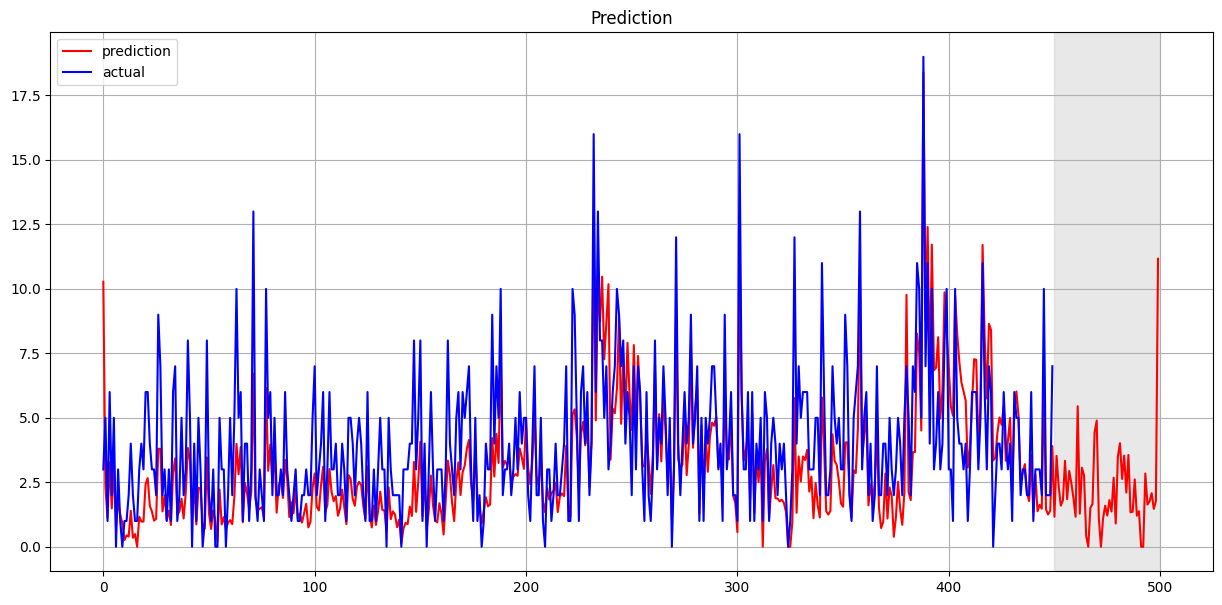

In [ ]:

pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test})
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()})
plt.figure(figsize=(15, 7))
plt.plot(model1, color='red', label="prediction")
plt.title("Prediction")
plt.plot(actual1, color='blue', label="actual")
#plt.plot(part2, label="actual1")
#plt.plot(part2, color='green', label='future')
#df_lstm_forecast = pd.DataFrame({'y':part2[0]}, index=dates)
#plt.plot(df_lstm_forecast, label="actual")
plt.legend()
plt.axvspan(len(actual1), len(model1), alpha=0.5, color='lightgrey')
plt.grid(True)